In [1]:
import numpy as np
import datetime as dt
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import dask
import xarray as xr
from dask.diagnostics import ProgressBar

In [139]:
import sys
print(sys.executable)

/home/srvx11/lehre/users/a1254888/.conda/envs/ml_flood2/bin/python3


In [140]:
def shift_time(ds, value):
    ds.coords['time'].values = pd.to_datetime(ds.coords['time'].values) + value
    return ds

In [141]:
static = xr.open_dataset('../data/usa/era5_slt_z_slor_lsm_stationary_field.nc')

In [142]:
era5 = xr.open_dataset('../data/usa/era5_lsp_cp_1981-2017_daysum.nc')

In [143]:
glofas = xr.open_dataset('../data/usa/glofas_reanalysis_usa_1981-2002.nc')
glofas = glofas.rename({'lat': 'latitude', 'lon': 'longitude'})  # to have the same name like in era5
glofas = shift_time(glofas, -dt.timedelta(days=1))
# da.transpose(dims='latitude')  # flip?

### time subset

In [144]:
era5 = era5.isel(time=slice(0*365,5*365))
glofas = glofas.isel(time=slice(0*365,5*365))

if len(era5.time) < 3000:
    era5 = era5.load()
    glofas = glofas.load()

### rough geographical subset

In [145]:
glofas.coords

Coordinates:
  * longitude  (longitude) float64 -124.9 -124.8 -124.7 ... -70.25 -70.15 -70.05
  * latitude   (latitude) float64 49.95 49.85 49.75 49.65 ... 25.25 25.15 25.05
  * time       (time) datetime64[ns] 1981-01-01 1981-01-02 ... 1985-12-30

In [146]:
glofas = glofas.sel(latitude=slice(40, 28), #28, 40),
                    longitude=slice(-95, -85))

## selection variables of interest

In [147]:
dis = glofas['dis']
X_dis = glofas

In [148]:
z_glofas = static['z'].isel(time=0)/9.81  # converting to m approx.
z_glofas = z_glofas.interp(latitude=glofas.latitude,
                           longitude=glofas.longitude)
z_glofas = z_glofas.drop('time')  # time is misleading as the topography does not change

##  find an interesting gridpoint to test

/home/srvx11/lehre/users/a1254888/.conda/envs/ml_flood2/lib/python3.7/site-packages/xarray/core/nputils.py:220: RuntimeWarning: All-NaN slice encountered
  result = getattr(npmodule, name)(values, axis=axis, **kwds)


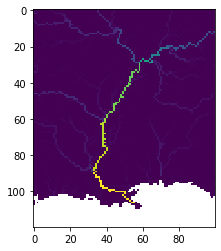

In [149]:
a = dis.max('time')
plt.imshow(a)

In [150]:
a = a[70,:]  # i want a gridpoint at this latitude
np.where(a==a.max()) #.sel(longitude=87).values =.max()

(array([38]),)

The most discharge is at gridpoint (70,38) of the box, so there is the river.

In [151]:
point = dict(latitude=70, longitude=38)
box = dict(latitude=slice(point['latitude']-10,
                          point['latitude']+10),
           longitude=slice(point['longitude']-10,
                           point['longitude']+10),)

In [152]:
X_dis = dis.isel(box)
y_dis = dis.isel(point)

/home/srvx11/lehre/users/a1254888/.conda/envs/ml_flood2/lib/python3.7/site-packages/xarray/core/nputils.py:220: RuntimeWarning: All-NaN slice encountered
  result = getattr(npmodule, name)(values, axis=axis, **kwds)


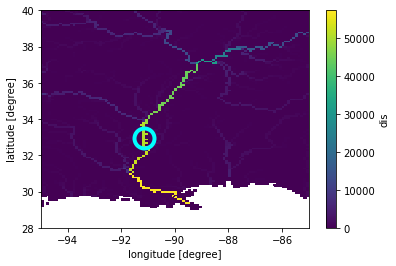

In [153]:
fig, ax = plt.subplots()
dis.max('time').plot(ax=ax)
ax.plot(y_dis.longitude, y_dis.latitude, color='cyan', marker='o', 
        markersize=20, mew=4, markerfacecolor='none')

## Feature selection

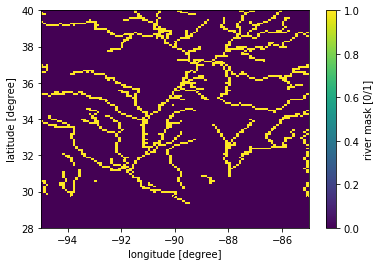

In [154]:
# rough river map
river = dis.min('time') > 5
river.name = 'river mask [0/1]'
river.plot()

In [155]:
i, j = 70, 38
di = 20
dj = 20
pct = 0.1  # influencing gridpoint must have mean discharge more than this percentage

In [156]:
i0, i1 = i-di, i+di
j0, j1 = j-dj, j+dj

meandis = dis.mean('time')
dis_box_mean = meandis[i0:i1,j0:j1]
z_box = z_glofas[i0:i1,j0:j1]
z_box.name = 'topography at river gridpoints [m]'

/home/srvx11/lehre/users/a1254888/.conda/envs/ml_flood2/lib/python3.7/site-packages/xarray/core/nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


### test time correlation as selection

In [157]:
def correlate(da_3d, da_timeseries, timelag=False):
    a = da_3d - da_3d.mean('time')
    b = da_timeseries - da_timeseries.mean('time')
    N = len(b.coords['time'])
    if timelag:
        b = b.drop('time')
        a = a.drop('time')
    out = b.dot(a)/a.std('time')/b.std()/N
    out.name = 'correlation coefficient'
    return out

/home/srvx11/lehre/users/a1254888/.conda/envs/ml_flood2/lib/python3.7/site-packages/xarray/core/nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/home/srvx11/lehre/users/a1254888/.conda/envs/ml_flood2/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1628: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)


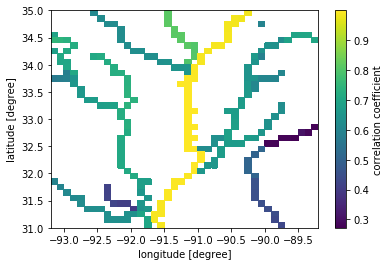

In [158]:
#for ic in range(i0, i1):
#    for jc in range(j0, j1):
cntr = dis[:,i,j]
dis_box = dis[:,i0:i1,j0:j1]
dis_box_relevant = dis_box.where(river==1)
a = correlate(dis_box_relevant, cntr)
a.plot()

### time lag correlation

/home/srvx11/lehre/users/a1254888/.conda/envs/ml_flood2/lib/python3.7/site-packages/xarray/core/nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/home/srvx11/lehre/users/a1254888/.conda/envs/ml_flood2/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1628: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)
/home/srvx11/lehre/users/a1254888/.conda/envs/ml_flood2/lib/python3.7/site-packages/xarray/core/nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/home/srvx11/lehre/users/a1254888/.conda/envs/ml_flood2/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1628: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)


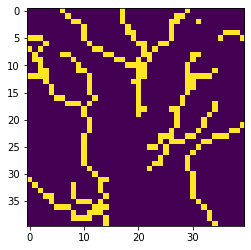

In [159]:
lags = [-1, 1]

timelag_corrs = np.full((len(lags), di*2, dj*2), np.nan)
for t, lag in enumerate(lags):
    if lag > 0:  # dis_box with data from previous timesteps
        cntr = dis[lag:,i,j]
        dis_box = dis[:-lag,i0:i1,j0:j1]
    elif lag < 0:  # dis_box with data from future timesteps
        cntr = dis[:lag,i,j]
        dis_box = dis[-lag:,i0:i1,j0:j1]
        
    dis_box_relevant = dis_box.where(river==1)
    timelag_corrs[t,:,:] = correlate(dis_box_relevant, cntr, timelag=True)

lag_influencing = timelag_corrs[1,:,:]>timelag_corrs[0,:,:]
plt.imshow(lag_influencing)

## putting everything together

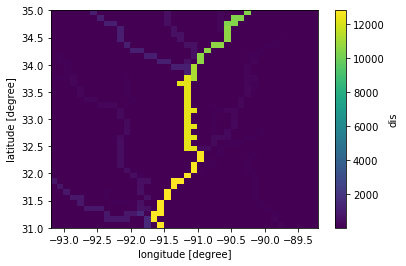

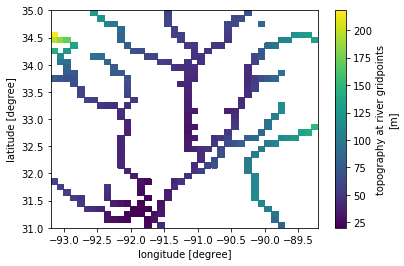

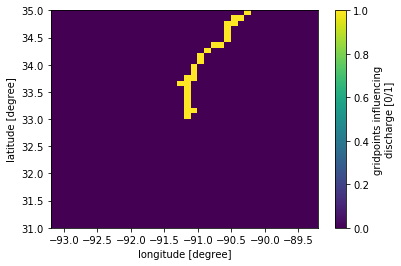

In [160]:
fig, ax = plt.subplots()
dis_box_mean.plot()

fig, ax = plt.subplots()
z_box.where(river==1).plot()

# select feature gridpoints
fig, ax = plt.subplots()
influencer = (dis_box_mean > pct*meandis[i,j])  \
              &(z_box >= z_glofas[i,j])   \
              &(river==1) & lag_influencing
influencer.name = 'gridpoints influencing discharge [0/1]'
influencer.plot()

### Reshape input for the neural network
(t-3, t-2, t-1) predict (t) discharge at some gridpoint using 64 nearby glofas gridpoints.
so we need to add those as additional predictors  and drop the current discharge (t)

In [161]:
def add_shifted_predictors(ds, shifts, variables='all'):
    """Adds additional variables to an array which are shifted in time.
    
    Parameters
    ----------
    ds : xr.Dataset
    shifts : list of integers
    variables : str or list
    """
    if variables == 'all': 
        variables = ds.data_vars
        
    for var in variables:
        for i in shifts:
            if i == 0: continue  # makes no sense to shift by zero
            newvar = var+'-'+str(i)
            ds[newvar] = ds[var].shift(time=i)
    return ds

In [162]:
X_dis = glofas.where(influencer)

In [163]:
# add (t-2) and (t-3) as additional features
shifts = range(1,4)
X_dis = add_shifted_predictors(X_dis, shifts, variables='all')
X_dis = X_dis.drop('dis')  # we actually want to predict (t) with (t-1, t-2, t-3)
X_dis

<xarray.Dataset>
Dimensions:    (latitude: 40, longitude: 40, time: 1825)
Coordinates:
  * latitude   (latitude) float64 34.95 34.85 34.75 34.65 ... 31.25 31.15 31.05
  * longitude  (longitude) float64 -93.15 -93.05 -92.95 ... -89.45 -89.35 -89.25
  * time       (time) datetime64[ns] 1981-01-01 1981-01-02 ... 1985-12-30
Data variables:
    dis-1      (time, latitude, longitude) float32 nan nan nan ... nan nan nan
    dis-2      (time, latitude, longitude) float32 nan nan nan ... nan nan nan
    dis-3      (time, latitude, longitude) float32 nan nan nan ... nan nan nan
Attributes:
    CDI:          Climate Data Interface version 1.6.4rc4 (http://code.zmaw.d...
    Conventions:  CF-1.4
    history:      Thu Jun 13 19:39:24 2019: cdo mergetime /home/srvx11/lehre/...
    CDO:          Climate Data Operators version 1.6.4rc7 (http://code.zmaw.d...

### reshape #2
lat, lon, time in along 1 dimension

In [164]:
# what currently is time, is in fact the number of samples we have
#X_atm = X_atm.rename(time='samples')  

# the different variables encode time features
X_dis = X_dis.to_array(dim='time_feature')  
X_dis

<xarray.DataArray (time_feature: 3, time: 1825, latitude: 40, longitude: 40)>
array([[[[nan, ..., nan],
         ...,
         [nan, ..., nan]],

        ...,

        [[nan, ..., nan],
         ...,
         [nan, ..., nan]]],


       ...,


       [[[nan, ..., nan],
         ...,
         [nan, ..., nan]],

        ...,

        [[nan, ..., nan],
         ...,
         [nan, ..., nan]]]], dtype=float32)
Coordinates:
  * latitude      (latitude) float64 34.95 34.85 34.75 ... 31.25 31.15 31.05
  * longitude     (longitude) float64 -93.15 -93.05 -92.95 ... -89.35 -89.25
  * time          (time) datetime64[ns] 1981-01-01 1981-01-02 ... 1985-12-30
  * time_feature  (time_feature) <U5 'dis-1' 'dis-2' 'dis-3'
Attributes:
    CDI:          Climate Data Interface version 1.6.4rc4 (http://code.zmaw.d...
    Conventions:  CF-1.4
    history:      Thu Jun 13 19:39:24 2019: cdo mergetime /home/srvx11/lehre/...
    CDO:          Climate Data Operators version 1.6.4rc7 (http://code.zmaw.d...

In [165]:
# our model needs spatial and time information as features, so we need to reshape
X_dis = X_dis.stack(features=['latitude', 'longitude', 'time_feature'])
#X_atm = X_atm.drop(['latitude', 'longitude', 'time_feature'])

X_dis

<xarray.DataArray (time: 1825, features: 4800)>
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]], dtype=float32)
Coordinates:
  * time          (time) datetime64[ns] 1981-01-01 1981-01-02 ... 1985-12-30
  * features      (features) MultiIndex
  - latitude      (features) float64 34.95 34.95 34.95 ... 34.95 34.95 34.95
  - longitude     (features) float64 -93.15 -93.15 -93.15 ... -92.25 -92.25
  - time_feature  (features) object 'dis-1' 'dis-2' 'dis-3' ... 'dis-2' 'dis-3'
Attributes:
    CDI:          Climate Data Interface version 1.6.4rc4 (http://code.zmaw.d...
    Conventions:  CF-1.4
    history:      Thu Jun 13 19:39:24 2019: cdo mergetime /home/srvx11/lehre/...
    CDO:          Climate Data Operators version 1.6.4rc7 (http://code.zmaw.d...

## Put all predictors together

In [166]:
Xar = X_dis
yar = dis[:,i,j]

In [167]:
yar = yar.drop(['latitude', 'longitude'])
#yar = yar.rename({'time': 'samples'})  # rename only to allow for concat to work to synchronize arrays
yar.coords['features'] = 'dis' #yar.expand_dims('features').T

# remove features that are nan
Xar = Xar.dropna('features', how='all')

In [168]:
Xar.shape

(1825, 78)

In [169]:
yar.shape

(1825,)

In [170]:
Xy = xr.concat([Xar, yar], dim='features')
Xy

<xarray.DataArray (time: 1825, features: 79)>
array([[       nan,        nan,        nan, ...,        nan,        nan,
         4880.3477],
       [ 4182.    ,        nan,        nan, ...,        nan,        nan,
         4851.875 ],
       [ 4166.663 ,  4182.    ,        nan, ...,  4875.5356,        nan,
         4825.1157],
       ...,
       [10994.827 , 11028.256 , 11070.171 , ..., 13915.65  , 14007.071 ,
        13747.259 ],
       [10968.417 , 10994.827 , 11028.256 , ..., 13823.966 , 13915.65  ,
        13669.984 ],
       [10946.475 , 10968.417 , 10994.827 , ..., 13738.404 , 13823.966 ,
        13601.375 ]], dtype=float32)
Coordinates:
  * time      (time) datetime64[ns] 1981-01-01 1981-01-02 ... 1985-12-30
  * features  (features) object (34.95, -90.24999999999999, 'dis-1') ... 'dis'

In [171]:
Xyt = Xy.dropna('time', how='any')  # drop them as we cannot train on nan values
time = Xyt.time

In [172]:
assert len(Xyt.time) > 1

In [174]:
Xyt

<xarray.DataArray (time: 1822, features: 79)>
array([[ 4151.1094,  4166.663 ,  4182.    , ...,  4847.2827,  4875.5356,
         4799.6724],
       [ 4134.447 ,  4151.1094,  4166.663 , ...,  4820.8086,  4847.2827,
         4776.4375],
       [ 4117.834 ,  4134.447 ,  4151.1094, ...,  4795.667 ,  4820.8086,
         4755.9233],
       ...,
       [10994.827 , 11028.256 , 11070.171 , ..., 13915.65  , 14007.071 ,
        13747.259 ],
       [10968.417 , 10994.827 , 11028.256 , ..., 13823.966 , 13915.65  ,
        13669.984 ],
       [10946.475 , 10968.417 , 10994.827 , ..., 13738.404 , 13823.966 ,
        13601.375 ]], dtype=float32)
Coordinates:
  * time      (time) datetime64[ns] 1981-01-04 1981-01-05 ... 1985-12-30
  * features  (features) object (34.95, -90.24999999999999, 'dis-1') ... 'dis'

In [175]:
Xda = Xyt[:,:-1]
yda = Xyt[:,-1]

In [176]:
Xda = Xda.chunk(dict(time=-1, features=-1)).data
yda = dask.array.from_array(yda.data.squeeze())

In [177]:
print('Xda.shape:', Xda.shape, 'yda.shape:',  yda.shape)

Xda.shape: (1822, 78) yda.shape: (1822,)


In [178]:
print(Xda, yda)

dask.array<xarray-<this-array>, shape=(1822, 78), dtype=float32, chunksize=(1822, 78)> dask.array<array, shape=(1822,), dtype=float32, chunksize=(1822,)>


In [179]:
import joblib
from sklearn.pipeline import Pipeline
from dask_ml.preprocessing import StandardScaler
from dask_ml.decomposition import PCA

#from dask_ml.xgboost import XGBRegressor
#from dask_ml.linear_model import LogisticRegression
from dask_ml.linear_model import LinearRegression

import keras
from keras.layers.core import Dropout

In [353]:
class KerasDenseNN(object):
    def __init__(self, **kwargs):
        model = keras.models.Sequential()
        self.cfg = kwargs
        ha = self.cfg.get('hidden_activation')

        for N_nodes in self.cfg.get('N_hidden_nodes'):
            # activation -> solve the dying ReLU problem
            # https://datascience.stackexchange.com/questions/5706/what-is-the-dying-relu-problem-in-neural-networks
            hidden = keras.layers.Dense(N_nodes)
            #            bias_initializer=self.cfg.get('bias_initializer'))

            model.add(hidden)
            model.add(keras.layers.Activation('tanh')) #keras.layers.ReLU())
            
            if self.cfg.get('dropout'):
                model.add(Dropout(self.cfg.get('dropout')))

        outputlayer = keras.layers.Dense(1, activation='linear')
        model.add(outputlayer)

        optimizer_name, options_dict = self.cfg.get('optimizer')
        optimizer = getattr(keras.optimizers, optimizer_name)(**options_dict)

        model.compile(loss=self.cfg.get('loss'), optimizer=optimizer)
        self.model = model

        self.callbacks = [keras.callbacks.EarlyStopping(monitor='loss',
                    min_delta=0.001, patience=100, verbose=0, mode='auto',
                    baseline=None, restore_best_weights=True),]

    def predict(self, X):
        return self.model.predict(X).squeeze()

    def fit(self, X, y, **kwargs):
        return self.model.fit(X, y,
                              epochs=self.cfg.get('epochs', None),
                              batch_size=self.cfg.get('batch_size', None),
                              callbacks=self.callbacks,
                              verbose=1,
                              **kwargs)

In [354]:
mlp_kws = dict(optimizer=('RMSprop', dict(lr=0.01)),
               loss='mean_squared_error',
               N_hidden_nodes=(4,4,),
               hidden_activation=keras.layers.Activation('tanh'), #keras.layers.ReLU(), #-LeakyReLU(alpha=0.3), #'relu',
               output_activation='linear',
               bias_initializer='zeros',
               batch_size=512,
               dropout=.0, #25,
               epochs=1000,
              )


linear_kws = dict(C=.1, n_jobs=-1, max_iter=10000, verbose=True)

if False:
    pipe = Pipeline([('scaler', StandardScaler()),
                     ('pca', PCA(n_components=4)),
                     ('model', LinearRegression(**linear_kws)),],
                    verbose=True)
if True:
    pipe = Pipeline([('scaler', StandardScaler()),
                     #('pca', PCA(n_components=4)),
                     ('model', KerasDenseNN(**mlp_kws)),],
                    verbose=True)

In [355]:
pipe

Pipeline(memory=None,
         steps=[('scaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('model', <__main__.KerasDenseNN object at 0x7fc9e1ec5b00>)],
         verbose=True)

In [356]:
#use_keras = 'Keras' in str(pipe.named_steps['model'].__class__)
#Xda_is_dask = isinstance(Xda, dask.array.core.Array)
#if use_keras and Xda_is_dask:
try:
    
    print('loading data...')
    Xda = Xda.persist()  # if loaded, stay loaded, dont clean
    Xda = Xda.compute()  # load data into RAM (convert to numpy array)
    yda = yda.compute()
except:
    pass

print(Xda.shape, yda.shape)

loading data...
(1822, 78) (1822,)


In [357]:
history = pipe.fit(Xda, yda)

[Pipeline] ............ (step 1 of 2) Processing scaler, total=   0.0s
Epoch 1/1000
1822/1822 [==============================] - 0s 3us/step - loss: 195346257.7387
Epoch 2/1000
1822/1822 [==============================] - 0s 2us/step - loss: 195328142.3666
Epoch 3/1000
1822/1822 [==============================] - 0s 2us/step - loss: 195314012.8738
Epoch 4/1000
1822/1822 [==============================] - 0s 2us/step - loss: 195304888.1668
Epoch 5/1000
1822/1822 [==============================] - 0s 2us/step - loss: 195290993.1240
Epoch 6/1000
1822/1822 [==============================] - 0s 2us/step - loss: 195278613.3392
Epoch 7/1000
1822/1822 [==============================] - 0s 2us/step - loss: 195267267.4599
Epoch 8/1000
1822/1822 [==============================] - 0s 2us/step - loss: 195260277.3568
Epoch 9/1000
1822/1822 [==============================] - 0s 2us/step - loss: 195252326.6564
Epoch 10/1000
1822/1822 [==============================] - 0s 2us/step - loss: 195239720.026

1822/1822 [==============================] - 0s 7us/step - loss: 194843323.6268
Epoch 87/1000
1822/1822 [==============================] - 0s 7us/step - loss: 194838420.7772
Epoch 88/1000
1822/1822 [==============================] - 0s 7us/step - loss: 194833504.5445
Epoch 89/1000
1822/1822 [==============================] - 0s 7us/step - loss: 194828588.7684
Epoch 90/1000
1822/1822 [==============================] - 0s 7us/step - loss: 194823662.5950
Epoch 91/1000
1822/1822 [==============================] - 0s 7us/step - loss: 194818752.2986
Epoch 92/1000
1822/1822 [==============================] - 0s 7us/step - loss: 194813825.3348
Epoch 93/1000
1822/1822 [==============================] - 0s 8us/step - loss: 194808915.3019
Epoch 94/1000
1822/1822 [==============================] - 0s 7us/step - loss: 194804021.1987
Epoch 95/1000
1822/1822 [==============================] - 0s 7us/step - loss: 194799091.4248
Epoch 96/1000
1822/1822 [==============================] - 0s 7us/step - l

1822/1822 [==============================] - 0s 7us/step - loss: 194420749.5763
Epoch 173/1000
1822/1822 [==============================] - 0s 7us/step - loss: 194415847.5697
Epoch 174/1000
1822/1822 [==============================] - 0s 7us/step - loss: 194410948.5840
Epoch 175/1000
1822/1822 [==============================] - 0s 7us/step - loss: 194406056.7113
Epoch 176/1000
1822/1822 [==============================] - 0s 7us/step - loss: 194401146.9594
Epoch 177/1000
1822/1822 [==============================] - 0s 7us/step - loss: 194396217.3611
Epoch 178/1000
1822/1822 [==============================] - 0s 7us/step - loss: 194391296.3337
Epoch 179/1000
1822/1822 [==============================] - 0s 7us/step - loss: 194386395.5565
Epoch 180/1000
1822/1822 [==============================] - 0s 7us/step - loss: 194381478.1647
Epoch 181/1000
1822/1822 [==============================] - 0s 7us/step - loss: 194376549.2865
Epoch 182/1000
1822/1822 [==============================] - 0s 7u

1822/1822 [==============================] - 0s 7us/step - loss: 193998820.4962
Epoch 259/1000
1822/1822 [==============================] - 0s 7us/step - loss: 193993925.2865
Epoch 260/1000
1822/1822 [==============================] - 0s 7us/step - loss: 193989040.5620
Epoch 261/1000
1822/1822 [==============================] - 0s 7us/step - loss: 193984137.6246
Epoch 262/1000
1822/1822 [==============================] - 0s 7us/step - loss: 193979206.9550
Epoch 263/1000
1822/1822 [==============================] - 0s 7us/step - loss: 193974293.1811
Epoch 264/1000
1822/1822 [==============================] - 0s 7us/step - loss: 193969382.2700
Epoch 265/1000
1822/1822 [==============================] - 0s 7us/step - loss: 193964480.7201
Epoch 266/1000
1822/1822 [==============================] - 0s 7us/step - loss: 193959574.9726
Epoch 267/1000
1822/1822 [==============================] - 0s 7us/step - loss: 193954675.6180
Epoch 268/1000
1822/1822 [==============================] - 0s 7u

1822/1822 [==============================] - 0s 7us/step - loss: 193577393.8793
Epoch 345/1000
1822/1822 [==============================] - 0s 7us/step - loss: 193572506.4149
Epoch 346/1000
1822/1822 [==============================] - 0s 8us/step - loss: 193567608.5708
Epoch 347/1000
1822/1822 [==============================] - 0s 7us/step - loss: 193562728.1844
Epoch 348/1000
1822/1822 [==============================] - 0s 7us/step - loss: 193557842.9506
Epoch 349/1000
1822/1822 [==============================] - 0s 7us/step - loss: 193552950.0768
Epoch 350/1000
1822/1822 [==============================] - 0s 7us/step - loss: 193548055.3414
Epoch 351/1000
1822/1822 [==============================] - 0s 7us/step - loss: 193543167.6487
Epoch 352/1000
1822/1822 [==============================] - 0s 7us/step - loss: 193538268.3820
Epoch 353/1000
1822/1822 [==============================] - 0s 7us/step - loss: 193533358.2613
Epoch 354/1000
1822/1822 [==============================] - 0s 7u

1822/1822 [==============================] - 0s 7us/step - loss: 193156599.9912
Epoch 431/1000
1822/1822 [==============================] - 0s 7us/step - loss: 193151711.9297
Epoch 432/1000
1822/1822 [==============================] - 0s 7us/step - loss: 193146824.9045
Epoch 433/1000
1822/1822 [==============================] - 0s 7us/step - loss: 193141981.2426
Epoch 434/1000
1822/1822 [==============================] - 0s 7us/step - loss: 193137100.5401
Epoch 435/1000
1822/1822 [==============================] - 0s 7us/step - loss: 193132210.3183
Epoch 436/1000
1822/1822 [==============================] - 0s 7us/step - loss: 193127312.1756
Epoch 437/1000
1822/1822 [==============================] - 0s 7us/step - loss: 193122405.5148
Epoch 438/1000
1822/1822 [==============================] - 0s 7us/step - loss: 193117517.7870
Epoch 439/1000
1822/1822 [==============================] - 0s 7us/step - loss: 193112615.6575
Epoch 440/1000
1822/1822 [==============================] - 0s 7u

1822/1822 [==============================] - 0s 7us/step - loss: 192736438.8672
Epoch 517/1000
1822/1822 [==============================] - 0s 7us/step - loss: 192731568.7201
Epoch 518/1000
1822/1822 [==============================] - 0s 7us/step - loss: 192726684.8913
Epoch 519/1000
1822/1822 [==============================] - 0s 7us/step - loss: 192721786.2217
Epoch 520/1000
1822/1822 [==============================] - 0s 7us/step - loss: 192716895.9649
Epoch 521/1000
1822/1822 [==============================] - 0s 7us/step - loss: 192712009.2382
Epoch 522/1000
1822/1822 [==============================] - 0s 7us/step - loss: 192707136.5093
Epoch 523/1000
1822/1822 [==============================] - 0s 7us/step - loss: 192702255.3502
Epoch 524/1000
1822/1822 [==============================] - 0s 7us/step - loss: 192697371.0823
Epoch 525/1000
1822/1822 [==============================] - 0s 7us/step - loss: 192692482.7223
Epoch 526/1000
1822/1822 [==============================] - 0s 7u

1822/1822 [==============================] - 0s 7us/step - loss: 192316822.8496
Epoch 603/1000
1822/1822 [==============================] - 0s 7us/step - loss: 192311921.0889
Epoch 604/1000
1822/1822 [==============================] - 0s 7us/step - loss: 192307057.7563
Epoch 605/1000
1822/1822 [==============================] - 0s 7us/step - loss: 192302194.6345
Epoch 606/1000
1822/1822 [==============================] - 0s 7us/step - loss: 192297316.8650
Epoch 607/1000
1822/1822 [==============================] - 0s 7us/step - loss: 192292482.0373
Epoch 608/1000
1822/1822 [==============================] - 0s 7us/step - loss: 192287602.9330
Epoch 609/1000
1822/1822 [==============================] - 0s 7us/step - loss: 192282701.7519
Epoch 610/1000
1822/1822 [==============================] - 0s 7us/step - loss: 192277801.7300
Epoch 611/1000
1822/1822 [==============================] - 0s 7us/step - loss: 192272941.3831
Epoch 612/1000
1822/1822 [==============================] - 0s 7u

1822/1822 [==============================] - 0s 7us/step - loss: 191897801.9407
Epoch 689/1000
1822/1822 [==============================] - 0s 7us/step - loss: 191892950.3403
Epoch 690/1000
1822/1822 [==============================] - 0s 7us/step - loss: 191888081.3172
Epoch 691/1000
1822/1822 [==============================] - 0s 7us/step - loss: 191883206.6389
Epoch 692/1000
1822/1822 [==============================] - 0s 7us/step - loss: 191878352.5269
Epoch 693/1000
1822/1822 [==============================] - 0s 7us/step - loss: 191873479.8858
Epoch 694/1000
1822/1822 [==============================] - 0s 7us/step - loss: 191868603.9254
Epoch 695/1000
1822/1822 [==============================] - 0s 7us/step - loss: 191863716.2151
Epoch 696/1000
1822/1822 [==============================] - 0s 7us/step - loss: 191858845.8397
Epoch 697/1000
1822/1822 [==============================] - 0s 7us/step - loss: 191853970.8101
Epoch 698/1000
1822/1822 [==============================] - 0s 7u

1822/1822 [==============================] - 0s 7us/step - loss: 191479452.2064
Epoch 775/1000
1822/1822 [==============================] - 0s 7us/step - loss: 191474598.1471
Epoch 776/1000
1822/1822 [==============================] - 0s 7us/step - loss: 191469744.6498
Epoch 777/1000
1822/1822 [==============================] - 0s 7us/step - loss: 191464881.8441
Epoch 778/1000
1822/1822 [==============================] - 0s 7us/step - loss: 191460000.3864
Epoch 779/1000
1822/1822 [==============================] - 0s 7us/step - loss: 191455139.5829
Epoch 780/1000
1822/1822 [==============================] - 0s 7us/step - loss: 191450279.0252
Epoch 781/1000
1822/1822 [==============================] - 0s 7us/step - loss: 191445393.9495
Epoch 782/1000
1822/1822 [==============================] - 0s 7us/step - loss: 191440527.0692
Epoch 783/1000
1822/1822 [==============================] - 0s 7us/step - loss: 191435646.7179
Epoch 784/1000
1822/1822 [==============================] - 0s 7u

1822/1822 [==============================] - 0s 7us/step - loss: 191061598.1910
Epoch 861/1000
1822/1822 [==============================] - 0s 7us/step - loss: 191056747.8902
Epoch 862/1000
1822/1822 [==============================] - 0s 7us/step - loss: 191051903.8946
Epoch 863/1000
1822/1822 [==============================] - 0s 7us/step - loss: 191047032.0615
Epoch 864/1000
1822/1822 [==============================] - 0s 7us/step - loss: 191042165.9188
Epoch 865/1000
1822/1822 [==============================] - 0s 7us/step - loss: 191037344.5093
Epoch 866/1000
1822/1822 [==============================] - 0s 7us/step - loss: 191032490.8013
Epoch 867/1000
1822/1822 [==============================] - 0s 7us/step - loss: 191027636.3557
Epoch 868/1000
1822/1822 [==============================] - 0s 7us/step - loss: 191022759.0252
Epoch 869/1000
1822/1822 [==============================] - 0s 7us/step - loss: 191017901.0318
Epoch 870/1000
1822/1822 [==============================] - 0s 7u

1822/1822 [==============================] - 0s 7us/step - loss: 190644376.7640
Epoch 947/1000
1822/1822 [==============================] - 0s 7us/step - loss: 190639513.6070
Epoch 948/1000
1822/1822 [==============================] - 0s 7us/step - loss: 190634649.7124
Epoch 949/1000
1822/1822 [==============================] - 0s 7us/step - loss: 190629817.6422
Epoch 950/1000
1822/1822 [==============================] - 0s 7us/step - loss: 190624960.3513
Epoch 951/1000
1822/1822 [==============================] - 0s 7us/step - loss: 190620127.3677
Epoch 952/1000
1822/1822 [==============================] - 0s 7us/step - loss: 190615265.3699
Epoch 953/1000
1822/1822 [==============================] - 0s 7us/step - loss: 190610405.9012
Epoch 954/1000
1822/1822 [==============================] - 0s 7us/step - loss: 190605550.1559
Epoch 955/1000
1822/1822 [==============================] - 0s 7us/step - loss: 190600727.0779
Epoch 956/1000
1822/1822 [==============================] - 0s 6u

In [358]:
keras.utils.print_summary(pipe.named_steps['model'].model)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_72 (Dense)             (None, 4)                 316       
_________________________________________________________________
activation_4 (Activation)    (None, 4)                 0         
_________________________________________________________________
dense_73 (Dense)             (None, 4)                 20        
_________________________________________________________________
activation_5 (Activation)    (None, 4)                 0         
_________________________________________________________________
dense_74 (Dense)             (None, 1)                 5         
Total params: 341
Trainable params: 341
Non-trainable params: 0
_________________________________________________________________


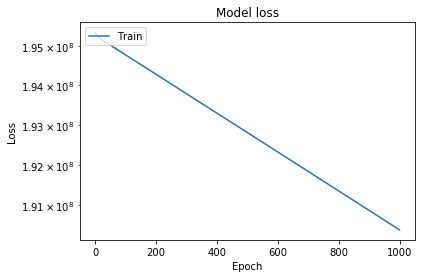

In [359]:
h = history.named_steps['model'].model.history

# Plot training & validation loss values
plt.plot(h.history['loss'])
#plt.plot(h.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.gca().set_yscale('log')
plt.show()

# Test it on the same data

In [360]:
def add_time(vector, time, name=None):
    """Converts arrays to xarrays with a time coordinate."""
    return xr.DataArray(vector, dims=('time'), coords={'time': time}, name=name)

In [361]:
with ProgressBar():
    ytest = pipe.predict(Xda)

In [362]:
ytest.shape

(1822,)

In [363]:
ytest = add_time(ytest, time, name='dis-forecast')
ytest_dis = ytest #.cumsum('time')
ytest_dis.values
#ytest_dis += y[0]  # initial state + changes = timeseries of forecasted discharge

array([203.43805, 203.43805, 203.43805, ..., 203.43158, 203.43158,
       203.43158], dtype=float32)

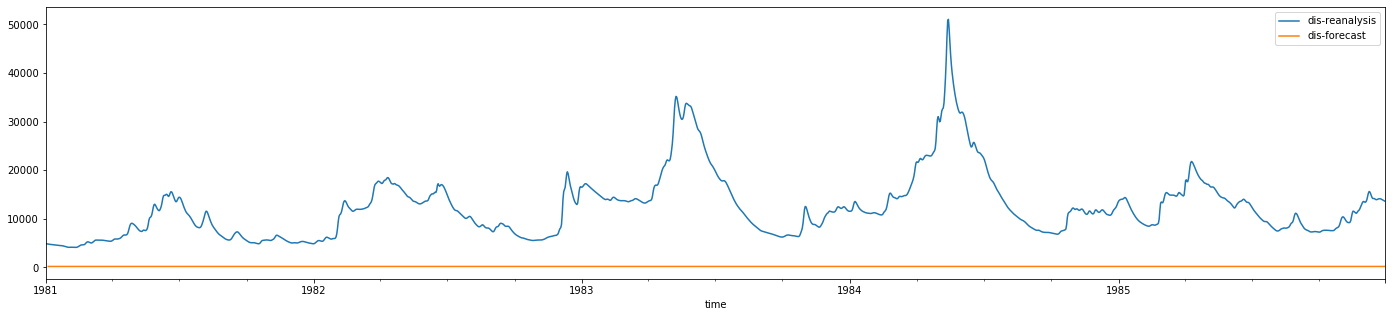

In [364]:
fig, ax = plt.subplots(figsize=(24,5))
obs = dis[:,i,j].to_pandas()
fcst = ytest_dis.to_pandas()
obs.plot(ax=ax, label='dis-reanalysis')
fcst.plot(ax=ax, label='dis-forecast')
plt.legend()

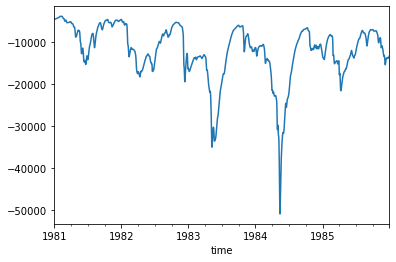

In [365]:
(fcst-obs).plot()

# FINISHED 
---